# Cluster then Classify Experiments on Schelling-satisfaction

Test data were generated assuming a uniform(0,1) distribution for bias and 10,000 simulations were run.  At each timestep, the percent of agents satisfied with their location (satisfactions) is computed and saved.  Each simulation is run for 10 timesteps. 

In [1]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.clustering import silhouette_score
import seaborn as sns
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import silhouette_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

2023-05-06 19:07:07.095084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
import random
random.seed(1)
os.environ['PYTHONHASHSEED']=str(1)

## Import simulation data - Schelling

In [3]:
os.chdir("/Users/maria/Desktop/Schelling_ML")
train_inputs = pd.read_csv('train_inputs_hap_0.csv')  
train_outputs = pd.read_csv('train_outputs_hap_0.csv')  
for i in range(1,100):
    filepath_in = 'train_inputs_hap_'+str(i)+'.csv'
    filepath_out = 'train_outputs_hap_'+str(i)+'.csv'
    file_in = pd.read_csv(filepath_in)
    file_out = pd.read_csv(filepath_out)
    train_inputs = pd.concat([train_inputs, file_in])
    train_outputs = pd.concat([train_outputs, file_out])

## Determine k for the satisfaction vectors - elbow method

2424.590 --> 2117.088 --> 2117.063 --> 2117.063 --> 
803.871 --> 715.274 --> 714.250 --> 713.550 --> 713.118 --> 712.961 --> 712.747 --> 712.368 --> 711.383 --> 709.065 --> 701.597 --> 681.489 --> 649.768 --> 637.902 --> 637.492 --> 637.492 --> 637.492 --> 
464.766 --> 330.177 --> 309.878 --> 269.810 --> 266.045 --> 266.044 --> 266.044 --> 
410.263 --> 200.461 --> 200.403 --> 200.403 --> 200.403 --> 
267.564 --> 101.847 --> 101.775 --> 101.775 --> 101.775 --> 
108.261 --> 67.689 --> 67.620 --> 67.620 --> 67.620 --> 
76.691 --> 50.179 --> 50.028 --> 50.004 --> 49.998 --> 49.996 --> 49.995 --> 49.995 --> 49.995 --> 
71.312 --> 48.097 --> 46.222 --> 45.713 --> 45.628 --> 45.615 --> 45.612 --> 45.610 --> 45.605 --> 45.596 --> 45.589 --> 45.588 --> 45.588 --> 45.588 --> 45.588 --> 
59.860 --> 45.790 --> 43.764 --> 43.190 --> 43.080 --> 43.057 --> 43.048 --> 43.042 --> 43.038 --> 43.031 --> 43.025 --> 43.023 --> 43.023 --> 43.023 --> 
51.038 --> 37.676 --> 35.195 --> 34.441 --> 34.261 --> 34

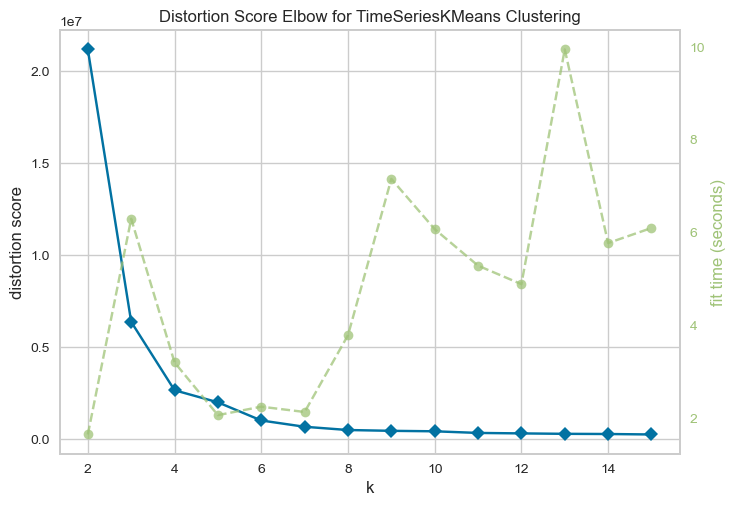

<Axes: title={'center': 'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
seed=1
X_train = to_time_series_dataset(train_inputs)
X_train_flat = [xi.flatten() for xi in X_train]

km = TimeSeriesKMeans(verbose=True, random_state=seed)
visualizer = KElbowVisualizer(km, k=(2,16), locate_elbow=False)
 
visualizer.fit(np.array(X_train_flat))        
visualizer.show()   

## Cluster on satisfaction vectors - Euclidean k-means

108.261 --> 67.689 --> 67.620 --> 67.620 --> 67.620 --> 


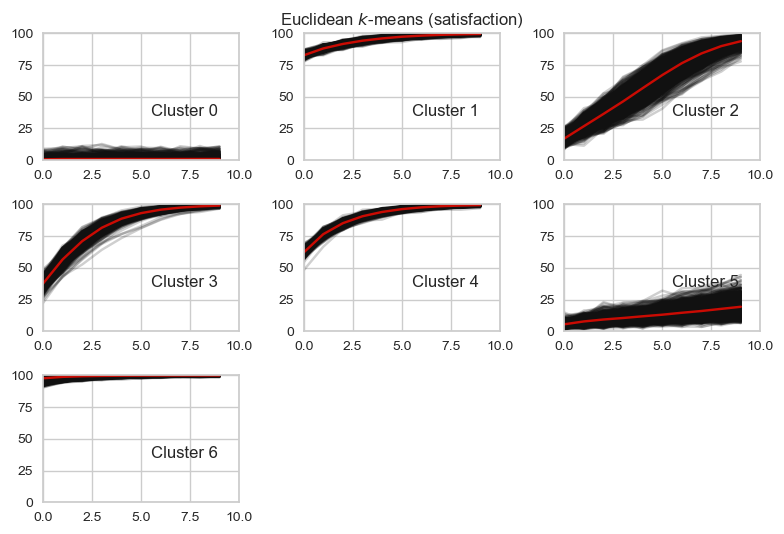

In [5]:
seed = 1
np.random.seed(seed)
sz = X_train.shape[1]

km = TimeSeriesKMeans(n_clusters=7, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
plt.figure()
for yi in range(7):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 100)
    plt.text(0.55, 0.35,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means (satisfaction)")
        
plt.tight_layout()
#plt.savefig('schelling_satisfaction_ts.svg')
plt.show()

In [6]:
train_outputs['Euclidean_labels'] = y_pred
train_outputs.reset_index(drop=True)

,0,Euclidean_labels
0,0.652377,2
1,0.062143,6
2,0.674791,2
3,0.595799,3
4,0.143759,6
...,...,...
9995,0.414441,4
9996,0.119902,6
9997,0.438393,4
9998,0.698130,2


## Cluster on satisfaction vectors - Soft DTW k-means

9888.770 --> 4972.651 --> 4643.881 --> 4589.170 --> 4556.650 --> 4541.445 --> 4530.382 --> 4524.667 --> 4518.806 --> 4514.306 --> 4510.799 --> 4513.681 --> 4511.513 --> 4513.446 --> 4511.742 --> 4513.229 --> 4511.949 --> 4513.106 --> 4512.024 --> 4513.055 --> 4511.950 --> 4513.066 --> 4511.659 --> 4513.160 --> 4511.197 --> 4513.778 --> 4510.649 --> 4514.791 --> 4510.200 --> 4514.578 --> 4510.760 --> 4513.670 --> 4510.813 --> 4513.646 --> 4510.953 --> 4513.551 --> 4511.043 --> 4513.750 --> 4510.988 --> 4514.029 --> 4510.832 --> 4514.503 --> 4510.072 --> 4514.961 --> 4509.758 --> 4513.826 --> 4510.045 --> 4512.672 --> 4510.371 --> 4512.330 --> 


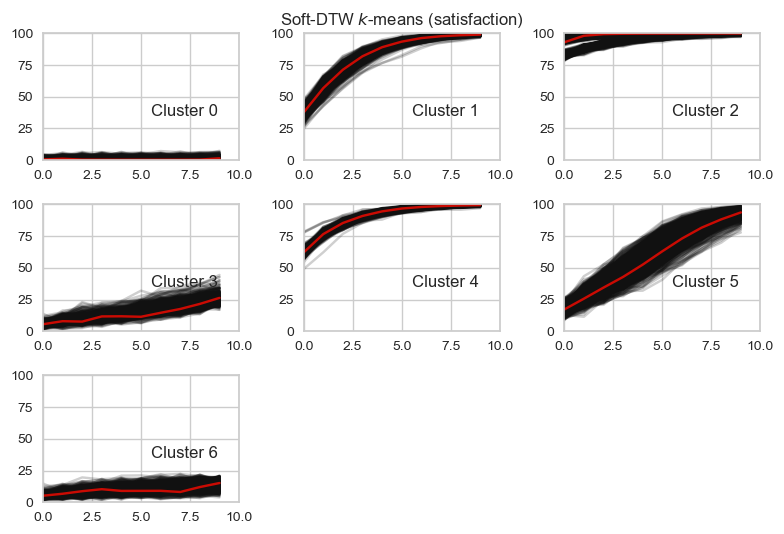

In [7]:
seed = 1
np.random.seed(seed)
sz = X_train.shape[1]

km = TimeSeriesKMeans(n_clusters=7, verbose=True, random_state=seed, metric="softdtw")
y_pred = km.fit_predict(X_train)
plt.figure()
for yi in range(7):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 100)
    plt.text(0.55, 0.35,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means (satisfaction)")
        
plt.tight_layout()
#plt.savefig('schelling_satisfaction_ts.svg')
plt.show()

In [8]:
train_outputs['softDTW_labels'] = y_pred
train_outputs.reset_index(drop=True)
train_outputs.to_csv("Schelling_satisfaction_kmeans_7.csv")

## Mapping the cluster labels back to the inputs - KNN - Euclidean - satisfaction

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_outputs['0'].values.reshape(-1, 1), train_outputs['Euclidean_labels'], test_size=0.1, random_state = 1)

#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
#print(sorted(Counter(y_resampled).items()))

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)

In [10]:
result = confusion_matrix(y_test, ypred)
print("Confusion Matrix:")
print(result)
report = classification_report(y_test, ypred)
print("Report:",)
print (report)
acc = accuracy_score(y_test,ypred)
print("Accuracy:",acc)

Confusion Matrix:
[[184   0   0   0   0   3   0]
 [  0  94   0   0   0   0   0]
 [  0   0 114   0   0   0   0]
 [  0   0   0 107   0   0   0]
 [  0   0   0   0 106   0   0]
 [  0   0   0   0   0  83   0]
 [  0   0   0   0   0   0 309]]
Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       187
           1       1.00      1.00      1.00        94
           2       1.00      1.00      1.00       114
           3       1.00      1.00      1.00       107
           4       1.00      1.00      1.00       106
           5       0.97      1.00      0.98        83
           6       1.00      1.00      1.00       309

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Accuracy: 0.997


## Mapping the cluster labels back to the inputs - MLP - Euclidean - satisfaction

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 7)                 63        
                                                                 
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
720/720 [==============================] - 2s 1ms/step - loss: 1.8392 - accuracy: 0.4399 - val_loss: 1.7766 - val_accuracy: 0.4939
Epoch 2/500
720/720 [==============================] - 1s 1ms/step - loss: 1.6704 - accuracy: 0.5111 - val_loss: 1.5858 - val_accuracy: 0.4939
Epoch 3/500
720/720 [==============================] - 1s 1ms/step - loss: 1.4707 - accuracy: 0.5111 - val_loss: 1.4067 - val_accuracy: 0.4939
Epoch 4/500
720/720 [======

720/720 [==============================] - 1s 1ms/step - loss: 0.4035 - accuracy: 0.9186 - val_loss: 0.4074 - val_accuracy: 0.9278
Epoch 54/500
720/720 [==============================] - 1s 1ms/step - loss: 0.4000 - accuracy: 0.9210 - val_loss: 0.4027 - val_accuracy: 0.9278
Epoch 55/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3964 - accuracy: 0.9236 - val_loss: 0.3988 - val_accuracy: 0.9350
Epoch 56/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3929 - accuracy: 0.9243 - val_loss: 0.3952 - val_accuracy: 0.9311
Epoch 57/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3896 - accuracy: 0.9256 - val_loss: 0.3935 - val_accuracy: 0.9250
Epoch 58/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3865 - accuracy: 0.9243 - val_loss: 0.3885 - val_accuracy: 0.9378
Epoch 59/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3832 - accuracy: 0.9215 - val_loss: 0.3856 - val_accuracy: 0.9400
Epoch

Epoch 110/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2829 - accuracy: 0.9561 - val_loss: 0.2832 - val_accuracy: 0.9650
Epoch 111/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2815 - accuracy: 0.9575 - val_loss: 0.2829 - val_accuracy: 0.9672
Epoch 112/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2804 - accuracy: 0.9608 - val_loss: 0.2838 - val_accuracy: 0.9478
Epoch 113/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2794 - accuracy: 0.9571 - val_loss: 0.2817 - val_accuracy: 0.9539
Epoch 114/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2781 - accuracy: 0.9574 - val_loss: 0.2791 - val_accuracy: 0.9639
Epoch 115/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2769 - accuracy: 0.9607 - val_loss: 0.2773 - val_accuracy: 0.9628
Epoch 116/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2757 - accuracy: 0.9581 - val_loss: 0.2795 - val_ac

720/720 [==============================] - 1s 1ms/step - loss: 0.2312 - accuracy: 0.9679 - val_loss: 0.2308 - val_accuracy: 0.9767
Epoch 167/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2304 - accuracy: 0.9701 - val_loss: 0.2308 - val_accuracy: 0.9706
Epoch 168/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2297 - accuracy: 0.9692 - val_loss: 0.2307 - val_accuracy: 0.9606
Epoch 169/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2292 - accuracy: 0.9682 - val_loss: 0.2295 - val_accuracy: 0.9744
Epoch 170/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2285 - accuracy: 0.9701 - val_loss: 0.2294 - val_accuracy: 0.9711
Epoch 171/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2277 - accuracy: 0.9707 - val_loss: 0.2283 - val_accuracy: 0.9717
Epoch 172/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2271 - accuracy: 0.9701 - val_loss: 0.2305 - val_accuracy: 0.9594

720/720 [==============================] - 1s 1ms/step - loss: 0.1998 - accuracy: 0.9739 - val_loss: 0.2000 - val_accuracy: 0.9767
Epoch 223/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1996 - accuracy: 0.9754 - val_loss: 0.1988 - val_accuracy: 0.9772
Epoch 224/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1993 - accuracy: 0.9743 - val_loss: 0.1996 - val_accuracy: 0.9733
Epoch 225/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1989 - accuracy: 0.9744 - val_loss: 0.1984 - val_accuracy: 0.9772
Epoch 226/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1983 - accuracy: 0.9761 - val_loss: 0.2008 - val_accuracy: 0.9756
Epoch 227/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1977 - accuracy: 0.9779 - val_loss: 0.1984 - val_accuracy: 0.9711
Epoch 228/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1975 - accuracy: 0.9732 - val_loss: 0.1985 - val_accuracy: 0.9717

720/720 [==============================] - 1s 1ms/step - loss: 0.1788 - accuracy: 0.9785 - val_loss: 0.1802 - val_accuracy: 0.9761
Epoch 279/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1788 - accuracy: 0.9769 - val_loss: 0.1786 - val_accuracy: 0.9794
Epoch 280/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1783 - accuracy: 0.9790 - val_loss: 0.1791 - val_accuracy: 0.9756
Epoch 281/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1779 - accuracy: 0.9776 - val_loss: 0.1780 - val_accuracy: 0.9850
Epoch 282/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1776 - accuracy: 0.9790 - val_loss: 0.1767 - val_accuracy: 0.9806
Epoch 283/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1773 - accuracy: 0.9751 - val_loss: 0.1770 - val_accuracy: 0.9806
Epoch 284/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1770 - accuracy: 0.9771 - val_loss: 0.1769 - val_accuracy: 0.9744

720/720 [==============================] - 1s 1ms/step - loss: 0.1634 - accuracy: 0.9790 - val_loss: 0.1650 - val_accuracy: 0.9817
Epoch 335/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1631 - accuracy: 0.9803 - val_loss: 0.1621 - val_accuracy: 0.9800
Epoch 336/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1629 - accuracy: 0.9782 - val_loss: 0.1621 - val_accuracy: 0.9867
Epoch 337/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1628 - accuracy: 0.9800 - val_loss: 0.1625 - val_accuracy: 0.9850
Epoch 338/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1624 - accuracy: 0.9799 - val_loss: 0.1626 - val_accuracy: 0.9739
Epoch 339/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1621 - accuracy: 0.9808 - val_loss: 0.1630 - val_accuracy: 0.9822
Epoch 340/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1619 - accuracy: 0.9792 - val_loss: 0.1615 - val_accuracy: 0.9844

720/720 [==============================] - 1s 1ms/step - loss: 0.1516 - accuracy: 0.9815 - val_loss: 0.1520 - val_accuracy: 0.9833
Epoch 391/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1513 - accuracy: 0.9818 - val_loss: 0.1525 - val_accuracy: 0.9750
Epoch 392/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1512 - accuracy: 0.9806 - val_loss: 0.1511 - val_accuracy: 0.9844
Epoch 393/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1511 - accuracy: 0.9810 - val_loss: 0.1513 - val_accuracy: 0.9839
Epoch 394/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1507 - accuracy: 0.9819 - val_loss: 0.1506 - val_accuracy: 0.9822
Epoch 395/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1507 - accuracy: 0.9812 - val_loss: 0.1499 - val_accuracy: 0.9828
Epoch 396/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1506 - accuracy: 0.9810 - val_loss: 0.1501 - val_accuracy: 0.9894

720/720 [==============================] - 1s 1ms/step - loss: 0.1419 - accuracy: 0.9824 - val_loss: 0.1422 - val_accuracy: 0.9828
Epoch 447/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1421 - accuracy: 0.9825 - val_loss: 0.1428 - val_accuracy: 0.9861
Epoch 448/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1414 - accuracy: 0.9819 - val_loss: 0.1415 - val_accuracy: 0.9822
Epoch 449/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1416 - accuracy: 0.9811 - val_loss: 0.1431 - val_accuracy: 0.9844
Epoch 450/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1414 - accuracy: 0.9831 - val_loss: 0.1417 - val_accuracy: 0.9872
Epoch 451/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1412 - accuracy: 0.9835 - val_loss: 0.1406 - val_accuracy: 0.9833
Epoch 452/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1412 - accuracy: 0.9810 - val_loss: 0.1410 - val_accuracy: 0.9844

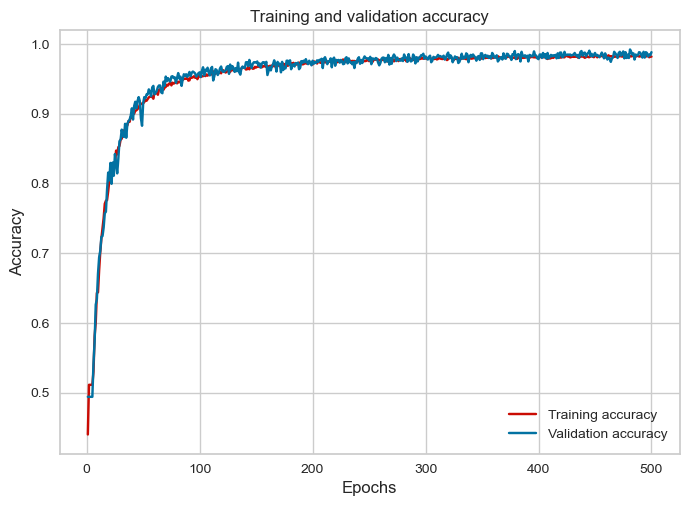

In [11]:
X = X_train
Y = y_train
dummy_y = np_utils.to_categorical(Y)

model = Sequential()
model.add(Dense(8, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True)

history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

preds = model.predict(X) 
print(preds[0]) 
print(np.sum(preds[0])) 

matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))

In [12]:
preds = model.predict(X_test) 
print("Report:",)
print(classification_report(y_test, preds.argmax(axis=1)))
acc = accuracy_score(y_test,preds.argmax(axis=1))
print("Accuracy:",acc)

32/32 [==============================] - 0s 859us/step
Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       187
           1       0.99      1.00      0.99        94
           2       1.00      0.98      0.99       114
           3       1.00      1.00      1.00       107
           4       1.00      0.99      1.00       106
           5       0.94      0.99      0.96        83
           6       1.00      1.00      1.00       309

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Accuracy: 0.993


## Mapping the cluster labels back to the inputs - KNN - soft-DTW - satisfaction

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_outputs['0'].values.reshape(-1, 1), train_outputs['softDTW_labels'], test_size=0.1, random_state = 1)

#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
#print(sorted(Counter(y_resampled).items()))

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)

In [14]:
result = confusion_matrix(y_test, ypred)
print("Confusion Matrix:")
print(result)
report = classification_report(y_test, ypred)
print("Report:",)
print (report)
acc = accuracy_score(y_test,ypred)
print("Accuracy:",acc)

Confusion Matrix:
[[184   0   0   0   0   0   0]
 [  0 107   0   0   0   0   0]
 [  0   0 403   0   0   0   0]
 [  0   0   0  10   0   0  30]
 [  0   0   0   0 106   0   0]
 [  0   0   0   0   0 114   0]
 [  0   0   0  17   0   0  29]]
Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       184
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00       403
           3       0.37      0.25      0.30        40
           4       1.00      1.00      1.00       106
           5       1.00      1.00      1.00       114
           6       0.49      0.63      0.55        46

    accuracy                           0.95      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.95      0.95      0.95      1000

Accuracy: 0.953


## Mapping the cluster labels back to the inputs - MLP - soft-DTW - satisfaction

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 16        
                                                                 
 dense_3 (Dense)             (None, 7)                 63        
                                                                 
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
720/720 [==============================] - 1s 1ms/step - loss: 1.7818 - accuracy: 0.4010 - val_loss: 1.6600 - val_accuracy: 0.3978
Epoch 2/500
720/720 [==============================] - 1s 1ms/step - loss: 1.5726 - accuracy: 0.4024 - val_loss: 1.4920 - val_accuracy: 0.3978
Epoch 3/500
720/720 [==============================] - 1s 1ms/step - loss: 1.4027 - accuracy: 0.5304 - val_loss: 1.3291 - val_accuracy: 0.5989
Epoch 4/500
720/720 [====

720/720 [==============================] - 1s 1ms/step - loss: 0.3088 - accuracy: 0.9336 - val_loss: 0.3097 - val_accuracy: 0.9267
Epoch 54/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3062 - accuracy: 0.9331 - val_loss: 0.3064 - val_accuracy: 0.9317
Epoch 55/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3034 - accuracy: 0.9342 - val_loss: 0.3027 - val_accuracy: 0.9261
Epoch 56/500
720/720 [==============================] - 1s 1ms/step - loss: 0.3007 - accuracy: 0.9319 - val_loss: 0.3038 - val_accuracy: 0.9311
Epoch 57/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2984 - accuracy: 0.9321 - val_loss: 0.2987 - val_accuracy: 0.9278
Epoch 58/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2958 - accuracy: 0.9346 - val_loss: 0.2970 - val_accuracy: 0.9400
Epoch 59/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2933 - accuracy: 0.9339 - val_loss: 0.2933 - val_accuracy: 0.9256
Epoch

Epoch 110/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2188 - accuracy: 0.9429 - val_loss: 0.2159 - val_accuracy: 0.9372
Epoch 111/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2179 - accuracy: 0.9426 - val_loss: 0.2162 - val_accuracy: 0.9422
Epoch 112/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2168 - accuracy: 0.9425 - val_loss: 0.2160 - val_accuracy: 0.9367
Epoch 113/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2162 - accuracy: 0.9435 - val_loss: 0.2151 - val_accuracy: 0.9422
Epoch 114/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2155 - accuracy: 0.9450 - val_loss: 0.2127 - val_accuracy: 0.9433
Epoch 115/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2147 - accuracy: 0.9457 - val_loss: 0.2115 - val_accuracy: 0.9389
Epoch 116/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2138 - accuracy: 0.9431 - val_loss: 0.2134 - val_ac

720/720 [==============================] - 1s 1ms/step - loss: 0.1837 - accuracy: 0.9454 - val_loss: 0.1820 - val_accuracy: 0.9444
Epoch 167/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1837 - accuracy: 0.9461 - val_loss: 0.1780 - val_accuracy: 0.9461
Epoch 168/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1828 - accuracy: 0.9463 - val_loss: 0.1818 - val_accuracy: 0.9383
Epoch 169/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1830 - accuracy: 0.9467 - val_loss: 0.1776 - val_accuracy: 0.9478
Epoch 170/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1822 - accuracy: 0.9469 - val_loss: 0.1778 - val_accuracy: 0.9433
Epoch 171/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1818 - accuracy: 0.9456 - val_loss: 0.1771 - val_accuracy: 0.9433
Epoch 172/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1813 - accuracy: 0.9478 - val_loss: 0.1794 - val_accuracy: 0.9372

720/720 [==============================] - 1s 1ms/step - loss: 0.1652 - accuracy: 0.9468 - val_loss: 0.1588 - val_accuracy: 0.9500
Epoch 223/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1650 - accuracy: 0.9483 - val_loss: 0.1600 - val_accuracy: 0.9450
Epoch 224/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1647 - accuracy: 0.9468 - val_loss: 0.1663 - val_accuracy: 0.9428
Epoch 225/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1648 - accuracy: 0.9479 - val_loss: 0.1592 - val_accuracy: 0.9444
Epoch 226/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1643 - accuracy: 0.9482 - val_loss: 0.1615 - val_accuracy: 0.9372
Epoch 227/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1640 - accuracy: 0.9479 - val_loss: 0.1587 - val_accuracy: 0.9400
Epoch 228/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1642 - accuracy: 0.9471 - val_loss: 0.1592 - val_accuracy: 0.9422

720/720 [==============================] - 1s 1ms/step - loss: 0.1533 - accuracy: 0.9490 - val_loss: 0.1510 - val_accuracy: 0.9461
Epoch 279/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1533 - accuracy: 0.9488 - val_loss: 0.1513 - val_accuracy: 0.9428
Epoch 280/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1531 - accuracy: 0.9481 - val_loss: 0.1482 - val_accuracy: 0.9450
Epoch 281/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1529 - accuracy: 0.9483 - val_loss: 0.1501 - val_accuracy: 0.9439
Epoch 282/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1526 - accuracy: 0.9483 - val_loss: 0.1463 - val_accuracy: 0.9483
Epoch 283/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1527 - accuracy: 0.9482 - val_loss: 0.1466 - val_accuracy: 0.9467
Epoch 284/500
720/720 [==============================] - 1s 1ms/step - loss: 0.1526 - accuracy: 0.9486 - val_loss: 0.1463 - val_accuracy: 0.9506

/Users/maria/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maria/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maria/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


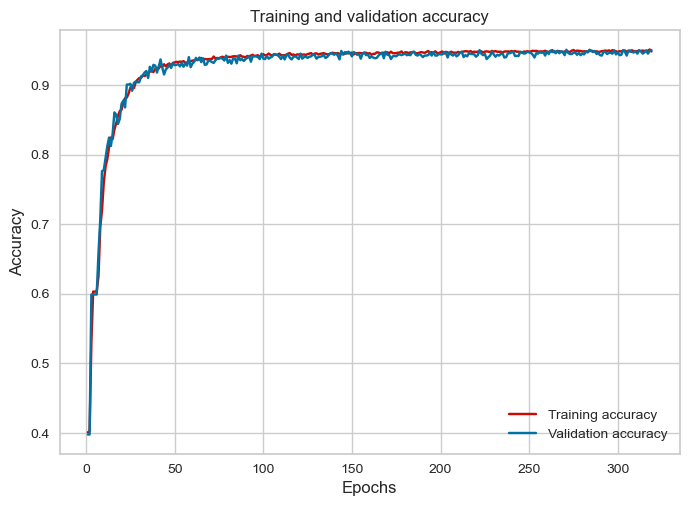

In [15]:
X = X_train
Y = y_train
dummy_y = np_utils.to_categorical(Y)

model = Sequential()
model.add(Dense(8, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True)

history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

preds = model.predict(X) 
print(preds[0]) 
print(np.sum(preds[0])) 

matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))

In [16]:
preds = model.predict(X_test) 
print("Report:",)
print(classification_report(y_test, preds.argmax(axis=1)))
acc = accuracy_score(y_test,preds.argmax(axis=1))
print("Accuracy:",acc)

32/32 [==============================] - 0s 969us/step
Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       184
           1       1.00      0.99      1.00       107
           2       1.00      1.00      1.00       403
           3       0.00      0.00      0.00        40
           4       1.00      0.99      1.00       106
           5       0.92      1.00      0.96       114
           6       0.50      0.83      0.62        46

    accuracy                           0.95      1000
   macro avg       0.77      0.83      0.80      1000
weighted avg       0.93      0.95      0.94      1000

Accuracy: 0.95


/Users/maria/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maria/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maria/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


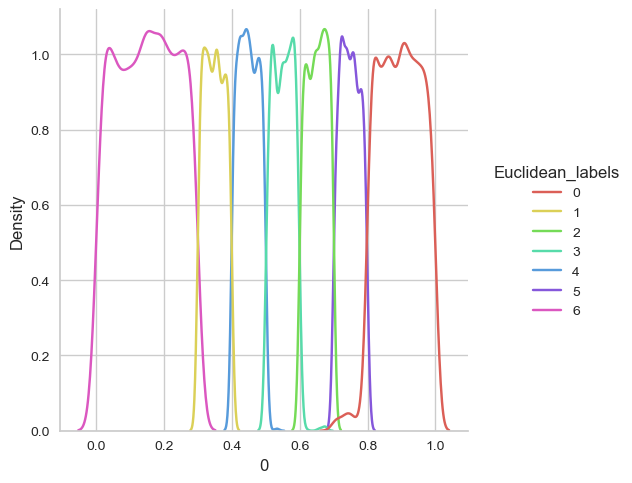

In [17]:
plt = sns.displot(data=train_outputs.reset_index(drop=True), x='0', hue="Euclidean_labels", kind="kde", palette=sns.color_palette("hls", 7))

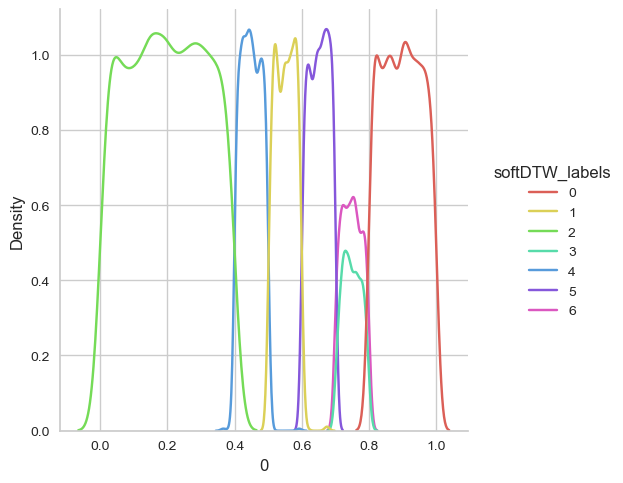

In [18]:
plt = sns.displot(data=train_outputs.reset_index(drop=True), x='0', hue="softDTW_labels", kind="kde", palette=sns.color_palette("hls", 7))

In [19]:
train_outputs

,0,Euclidean_labels,softDTW_labels
0,0.652377,2,5
1,0.062143,6,2
2,0.674791,2,5
3,0.595799,3,1
4,0.143759,6,2
...,...,...,...
95,0.414441,4,4
96,0.119902,6,2
97,0.438393,4,4
98,0.698130,2,5
